<a href="https://colab.research.google.com/github/yousraBRK/SqueezeNet_VGG_FineTunning_CIFAR10/blob/main/SqueezeNet_VGG_FineTunning_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import time
import copy
from collections import defaultdict

from pylab import rcParams

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import sampler,DataLoader
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from torch.optim import lr_scheduler

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import cv2 as cv

from sklearn.metrics import confusion_matrix, classification_report

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

In [5]:
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [6]:
trainset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
           )

In [7]:

testset
size_test = 10000


In [8]:
class ChunkSampler(sampler.Sampler):
    """Samples elements sequentially from some offset. 
    Arguments:
        num_samples: # of desired datapoints
        start: offset where we should start selecting from
    """
    def __init__(self, num_samples, start = 0):
        self.num_samples = num_samples
        self.start = start

    def __iter__(self):
        return iter(range(self.start, self.start + self.num_samples))

    def __len__(self):
        return self.num_samples

In [9]:
NUM_TRAIN = 49000
NUM_VAL = 1000

loader_train = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_TRAIN, 0))

loader_val = DataLoader(trainset, batch_size=16,num_workers=4,sampler=ChunkSampler(NUM_VAL, NUM_TRAIN))

In [10]:
dataloaders = {'train':loader_train,'val':loader_val}
dataset_sizes = {'train':NUM_TRAIN,'val':NUM_VAL}

In [11]:
loader_test = DataLoader(testset, batch_size=16, shuffle=True,num_workers=4)

In [12]:

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [13]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    history = defaultdict(list)
    model = model.to(device)

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            current_loss = 0.0
            current_corrects = 0

            # Here's where the training happens
            print('Iterating through data...')

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # We need to zero the gradients, don't forget it
                optimizer.zero_grad()

                # Time to carry out the forward training poss
                # We only need to log the loss stats if we are in training phase
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _,preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # We want variables to hold the loss statistics
                current_loss += loss.item() * inputs.size(0)
                current_corrects += torch.sum(preds == labels.data)

            epoch_loss = current_loss / dataset_sizes[phase]
            epoch_acc = current_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            if phase == 'train' :
                train_acc = epoch_acc
                train_loss = epoch_loss 
            else :
                val_acc = epoch_acc 
                val_loss = epoch_loss 

            # Make a copy of the model if the accuracy on the validation set has improved
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model.state_dict(), 'best_model_state.bin')

        history['train_acc'].append(train_acc)
        history['train_loss'].append(train_loss)
        history['val_acc'].append(val_acc)
        history['val_loss'].append(val_loss)
        print()

    time_since = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_since // 60, time_since % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # Now we'll load in the best model weights and return it
    model.load_state_dict(best_model_wts)
    model = model.to(device)
    return model,history

In [14]:
def eval_model(model, data_loader, loss_fn):
    model = model.eval()

    losses = []
    correct_predictions = 0
    model = model.to(device)
    loss_fn = loss_fn.to(device)

    with torch.no_grad():
        for d in data_loader:

            # Preparing inputs
            images, targets = d
            targets = targets.to(device)
            images = images.to(device)
            

            # Running inference using the model

            outputs = model(images)
            
            # Running softmax on the outputs
            _, preds = torch.max(outputs.data, dim=1)

            # Computing loss function
            loss = loss_fn(outputs, targets)

            # Counting the correct occurences
            correct_predictions += torch.sum(preds == targets)

            # Computing the precision (true positives/true positives + false positives) 
            # for each class and label, and find their average weighted by support 

            losses.append(loss.item())

    return correct_predictions.double() / 10000, np.mean(losses)

In [15]:

squeeze = torchvision.models.squeezenet1_0(pretrained=True)
squeeze.classifier._modules["1"] = nn.Conv2d(512, len(classes), kernel_size=(1, 1))
squeeze.num_classes = len(classes)


Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth


In [ ]:
print(squeeze)

SqueezeNet(
  (features): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    (3): Fire(
      (squeeze): Conv2d(96, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (4): Fire(
      (squeeze): Conv2d(128, 16, kernel_size=(1, 1), stride=(1, 1))
      (squeeze_activation): ReLU(inplace=True)
      (expand1x1): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1))
      (expand1x1_activation): ReLU(inplace=True)
      (expand3x3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (expand3x3_activation): ReLU(inplace=True)
    )
    (5): Fire(
   

In [16]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.SGD(squeeze.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

In [ ]:
base_model,history = train_model(squeeze, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

Epoch 1/15
----------
Iterating through data...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


train Loss: 1.9339 Acc: 0.2772
Iterating through data...
val Loss: 1.2095 Acc: 0.5530

Epoch 2/15
----------
Iterating through data...
train Loss: 1.0952 Acc: 0.6300
Iterating through data...
val Loss: 1.0568 Acc: 0.6310

Epoch 3/15
----------
Iterating through data...
train Loss: 0.8937 Acc: 0.7006
Iterating through data...
val Loss: 0.9125 Acc: 0.6800

Epoch 4/15
----------
Iterating through data...


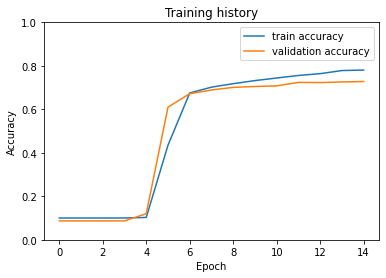

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

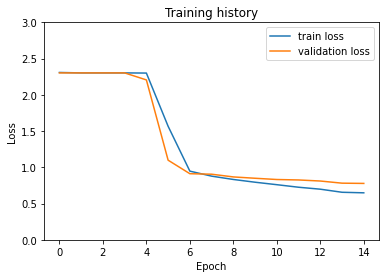

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);

In [ ]:
test_acc, _ = eval_model(base_model,loader_test,criterion)
print('Accuracy on the test set is %.2f %%' %test_acc.item() )

Accuracy on the test set is 0.74 %


In [ ]:
# Simple Identity class that let's input pass without changes
class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x

In [ ]:
# Load pretrain model & modify it
VGGNet = torchvision.models.vgg16(pretrained=True)

# If you want to do finetuning then set requires_grad = False
# Remove these two lines if you want to train entire model,
# and only want to load the pretrain weights.
for param in VGGNet.parameters():
    param.requires_grad = False

VGGNet.avgpool = Identity()
VGGNet.classifier = nn.Sequential(nn.Linear(512, 100), nn.ReLU(), nn.Linear(100, len(classes)))
VGGNet.num_classes = len(classes)

In [1]:
base_model,history = train_model(VGGNet, criterion, optimizer, exp_lr_scheduler, num_epochs=15)

NameError: ignored

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [ ]:
# Plotting the results of the training and validation accuracy using the stored information in history
plt.plot(history['train_loss'], label='train loss')
plt.plot(history['val_loss'], label='validation loss')

plt.title('Training history')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 3]);